In [1]:
!pip install facenet-pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as patches
import pandas
import numpy as np
import seaborn
import cv2
import os
from time import time
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Нужна

In [3]:
def detect_faces(img, min_conf=0.96, size=256, margin=0.3):
    mtcnn = MTCNN(keep_all=True, device=device)
    boxes, probs = mtcnn.detect(img, landmarks=False)

    img_w, img_h = img.size
    faces = []
    coords = []
    fig, ax = plt.subplots()
    ax.imshow(img)

    for box, p in zip(boxes, probs):
        if p is None or p < min_conf:
            continue
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        x1_new = max(int(x1 - w * margin), 0)
        y1_new = max(int(y1 - h * margin), 0)
        x2_new = min(int(x2 + w * margin), img_w)
        y2_new = min(int(y2 + h * margin), img_h)

        face = img.crop((x1_new, y1_new, x2_new, y2_new)).resize((size, size))
        face_tensor = TF.to_tensor(face)
        faces.append(face_tensor)
        coords.append((x1_new, y1_new, x2_new, y2_new))

    face_batch = torch.stack(faces) if faces else torch.empty(0)
    num_faces = len(face_batch)

    print(f"Найдено лиц: {num_faces}")
    print(f"Размер батча: {face_batch.shape}")  # [N, 3, 256, 256]
    plt.axis("off")
    plt.show()
    return face_batch, coords


Нужна

In [4]:
def extract_landmarks_from_heatmaps(heatmaps, upscale=4):
    """
    :param heatmaps: [B, 5, 64, 64]
    :return: список [B] из массивов ключевых точек shape (5, 2)
    """
    coords_batch = []
    for hm in heatmaps:
        coords = []
        for channel in hm:
            y, x = np.unravel_index(np.argmax(channel), channel.shape)
            coords.append([x * upscale, y * upscale])
        coords_batch.append(np.array(coords, dtype=np.float32))
    return coords_batch


Нужна

In [5]:
def align_faces(face_batch, landmark_batch, output_size=(112, 112)):
    standard = np.array([
        [30.2946, 51.6963],
        [65.5318, 51.5014],
        [48.0252, 71.7366],
        [33.5493, 92.3655],
        [62.7299, 92.2041]
    ], dtype=np.float32)

    if output_size[0] != 112:
        standard *= (output_size[0] / 112)

    aligned_faces = []

    for img_tensor, landmarks in zip(face_batch, landmark_batch):
        img = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        M = cv2.estimateAffinePartial2D(landmarks, standard, method=cv2.LMEDS)[0]
        aligned = cv2.warpAffine(img, M, output_size, borderValue=0)
        aligned_tensor = TF.to_tensor(Image.fromarray(aligned))
        aligned_faces.append(aligned_tensor)

    return torch.stack(aligned_faces)


Нужна

In [6]:
def show_faces(face_batch, titles=None, suptitle=None):
    n = len(face_batch)
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    if n == 1:
        axes = [axes]

    for i in range(n):
        img = face_batch[i].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        if titles:
            axes[i].set_title(titles[i])
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


Нужна

In [7]:
def show_faces_with_landmarks(face_batch, landmarks_batch, suptitle=None):
    n = len(face_batch)
    fig, axes = plt.subplots(1, n, figsize=(n * 3, 3))
    if n == 1:
        axes = [axes]

    for i in range(n):
        img = face_batch[i].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img)
        axes[i].axis("off")
        for (x, y) in landmarks_batch[i]:
            axes[i].plot(x, y, 'ro')
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


Нужна

In [8]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = out_channels // 2

        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, mid_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        skip = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + skip)

class Hourglass(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.channels = channels

        self.skip = Residual(channels, channels)
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            Residual(channels, channels)
        )

        if depth > 1:
            self.inner = Hourglass(depth - 1, channels)
        else:
            self.inner = Residual(channels, channels)

        self.up = Residual(channels, channels)

    def forward(self, x):
        skip = self.skip(x)
        x = self.down(x)
        x = self.inner(x)
        x = self.up(F.interpolate(x, scale_factor=2, mode='nearest'))
        return x + skip

class HourglassBlock(nn.Module):
    def __init__(self, depth, channels, num_keypoints):
        super().__init__()
        self.hourglass = Hourglass(depth, channels)
        self.res = Residual(channels, channels)
        self.out_heatmap = nn.Conv2d(channels, num_keypoints, kernel_size=1)

        # intermediate supervision:
        self.out_feature = nn.Conv2d(channels, channels, kernel_size=1)
        self.out_heatmap_to_feat = nn.Conv2d(num_keypoints, channels, kernel_size=1)

    def forward(self, x):
        hg = self.hourglass(x)
        feat = self.res(hg)
        heatmap = self.out_heatmap(feat)
        feat_next = x + self.out_feature(feat) + self.out_heatmap_to_feat(heatmap)
        return heatmap, feat_next

class StackedHourglassNet(nn.Module):
    def __init__(self, num_stacks, num_blocks, channels, num_keypoints):
        super().__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Residual(64, 128),
            nn.MaxPool2d(2),
            Residual(128, 128),
            Residual(128, channels)
        )

        self.stacks = nn.ModuleList([
            HourglassBlock(num_blocks, channels, num_keypoints)
            for _ in range(num_stacks)
        ])

    def forward(self, x):
        x = self.pre(x)
        outputs = []

        for stack in self.stacks:
            heatmap, x = stack(x)
            outputs.append(heatmap)

        return outputs  # список [B, num_keypoints, 64, 64]

Нужна

In [9]:
def get_embeddings(face_batch, backbone):
    backbone.eval()
    with torch.no_grad():
        features = backbone(face_batch.to(device))  # [B, 256]
        embeddings = F.normalize(features, dim=1)   # ArcFace требует L2-нормировку
    return embeddings

In [11]:
# 2. Загружаем Hourglass и ArcFace-модель
hourglass = StackedHourglassNet(num_stacks=2, num_blocks=4, channels=128, num_keypoints=5)
hourglass.load_state_dict(torch.load("/content/shg_amazing.pth", map_location='cpu'))
hourglass = hourglass.to(device).eval()

hybrid_backbone = models.resnet50(pretrained=False)
hybrid_backbone.fc = nn.Sequential(
    nn.Linear(hybrid_backbone.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3)
)

checkpoint = torch.load("/content/resnet_hybrid_best.pth", map_location=torch.device('cpu'))

hybrid_backbone.load_state_dict(checkpoint['backbone_state'])
hybrid_backbone = hybrid_backbone.to(device).eval()

In [12]:
def process_image(img_path, landmark_model, backbone_model):
    img = Image.open(img_path).convert("RGB")
    faces, _ = detect_faces(img)
    if len(faces) == 0:
        return [], [], [], []

    with torch.no_grad():
        heatmaps = landmark_model(faces.to(device))[-1].cpu().numpy()
    landmarks = extract_landmarks_from_heatmaps(heatmaps)
    aligned = align_faces(faces, landmarks)

    show_faces_with_landmarks(faces, landmarks, suptitle=f"{path} — Keypoints")
    show_faces(aligned, suptitle=f"{path} — Aligned")


    embeddings = get_embeddings(aligned, backbone_model)

    basename = os.path.basename(img_path)
    labels = [f"{basename}_face{i+1}" for i in range(len(embeddings))]
    return embeddings, labels, aligned, [basename] * len(embeddings)


In [13]:
def compute_all_pairwise_metrics(embeddings, labels):
    n = len(embeddings)
    results = []

    for i in range(n):
        for j in range(i + 1, n):
            emb1 = embeddings[i].view(1, -1)
            emb2 = embeddings[j].view(1, -1)
            l2_dist = F.pairwise_distance(emb1, emb2).item()
            cos_sim = F.cosine_similarity(emb1, emb2).item()

            results.append({
                'i': i,
                'j': j,
                'label_i': labels[i],
                'label_j': labels[j],
                'l2': l2_dist,
                'cos': cos_sim
            })

    return sorted(results, key=lambda x: -x['cos'])

In [14]:
def visualize_top_k_pairs(results, face_images, k=5):
    top_pairs = results[:k]
    for pair in top_pairs:
        i, j = pair['i'], pair['j']
        label = f"{pair['label_i']} vs {pair['label_j']}\nL2: {pair['l2']:.4f} | CosSim: {pair['cos']:.4f}"

        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        for ax, face in zip(axes, [face_images[i], face_images[j]]):
            ax.imshow(face.permute(1, 2, 0).cpu().numpy())
            ax.axis("off")
        fig.suptitle(label, fontsize=10)
        plt.tight_layout()
        plt.show()


In [15]:
import seaborn as sns
import pandas as pd

def compute_l2_distance(emb1, emb2):
    emb1 = emb1.view(1, -1)
    emb2 = emb2.view(1, -1)
    return F.pairwise_distance(emb1, emb2).item()

def compute_cosine_similarity(emb1, emb2):
    emb1 = emb1.view(-1)
    emb2 = emb2.view(-1)
    return F.cosine_similarity(emb1, emb2, dim=0).item()

def plot_distance_matrix(embeddings, labels, metric='cos'):
    n = len(embeddings)
    values = []

    for i in range(n):
        row = []
        for j in range(n):
            if metric == 'l2':
                dist = compute_l2_distance(embeddings[i], embeddings[j])
            elif metric == 'cos':
                dist = 1 - compute_cosine_similarity(embeddings[i], embeddings[j])  # 1 - cos → как "расстояние"
            else:
                raise ValueError("metric must be 'l2' or 'cos'")
            row.append(dist)
        values.append(row)

    df = pd.DataFrame(values, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=False, cmap='viridis', xticklabels=True, yticklabels=True)
    plt.title(f"Pairwise {'L2' if metric=='l2' else '1 - CosSim'} distance matrix")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


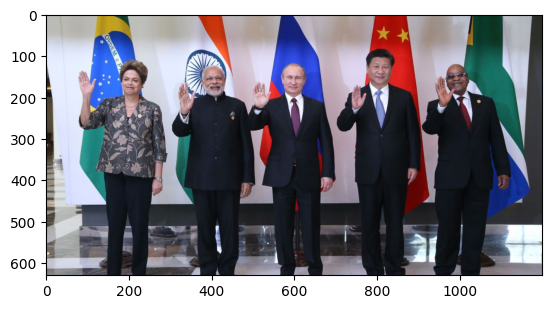

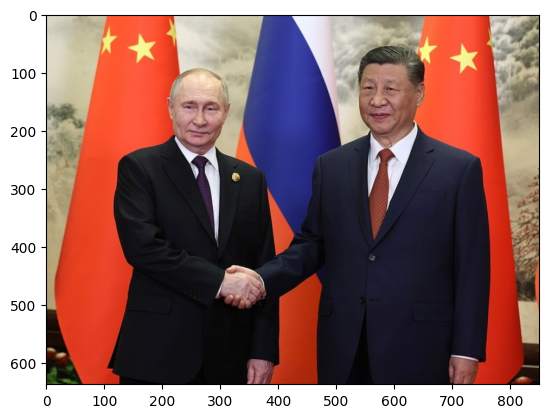

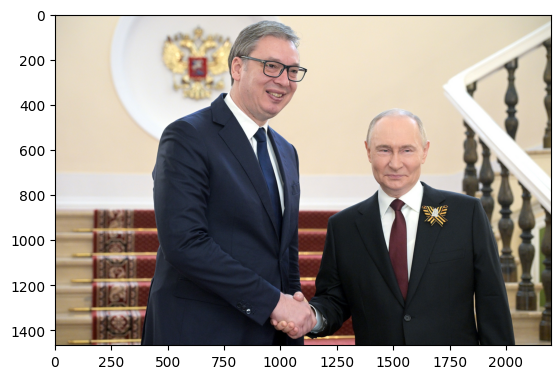

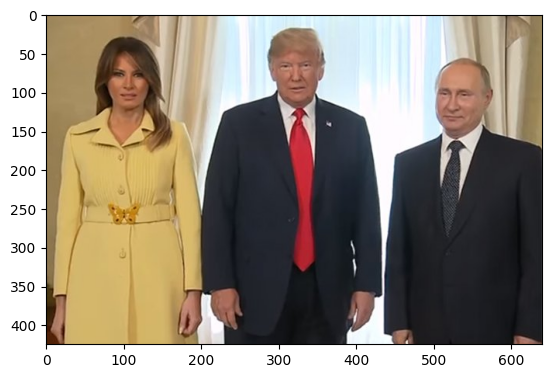

In [16]:
image_paths = [
    "/content/img1.jpg",
    "/content/img4.jpg",
    "/content/img5.jpg",
    "/content/img6.jpg"
]
for path in image_paths:
  img = Image.open(path).convert("RGB")
  plt.imshow(img)
  plt.show()

Найдено лиц: 5
Размер батча: torch.Size([5, 3, 256, 256])


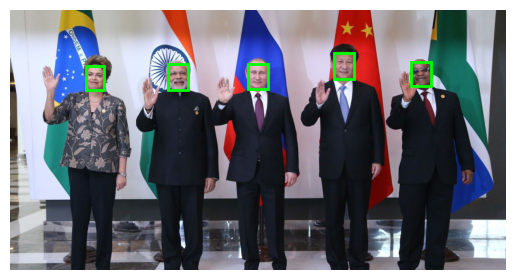

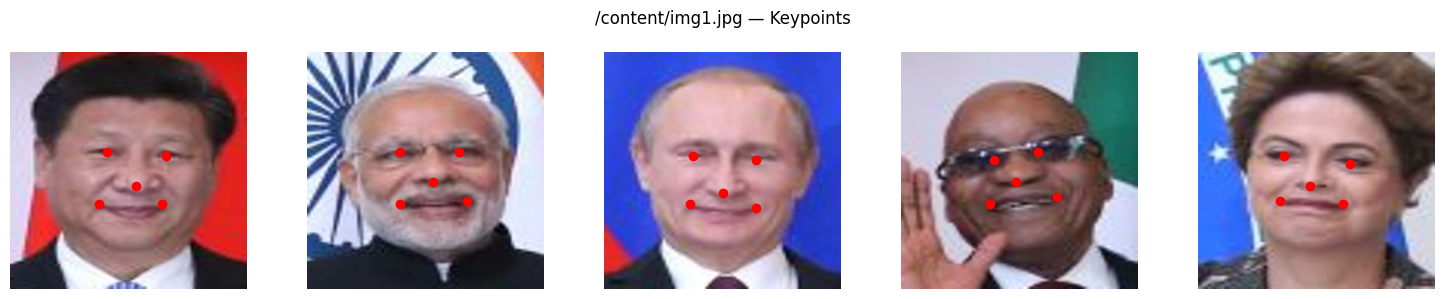

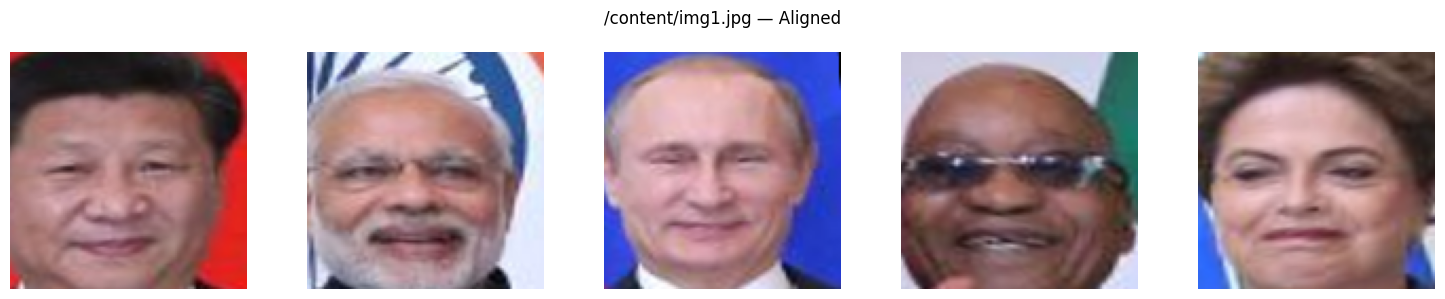

Найдено лиц: 2
Размер батча: torch.Size([2, 3, 256, 256])


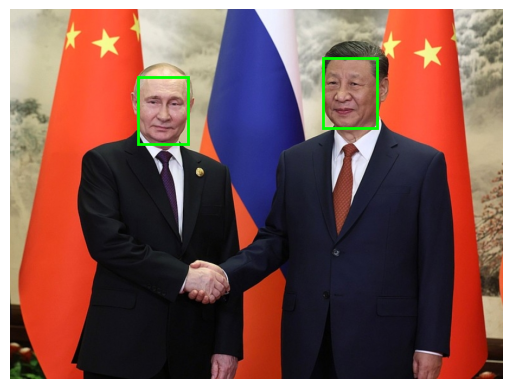

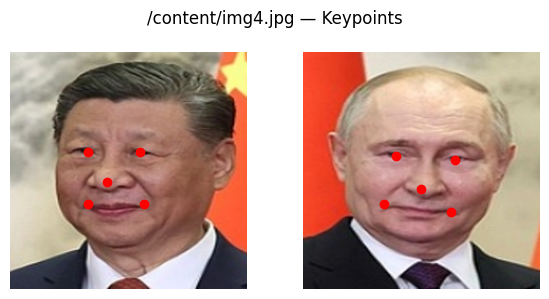

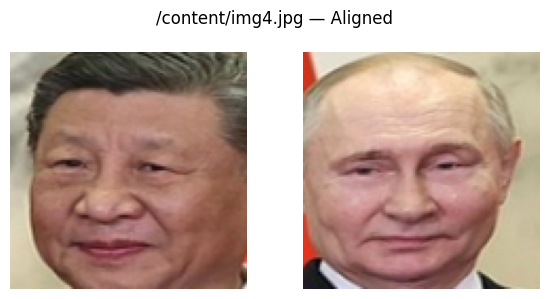

Найдено лиц: 2
Размер батча: torch.Size([2, 3, 256, 256])


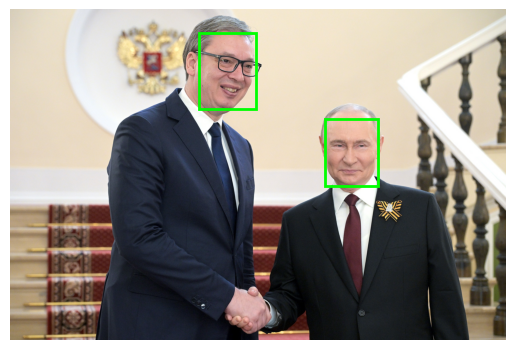

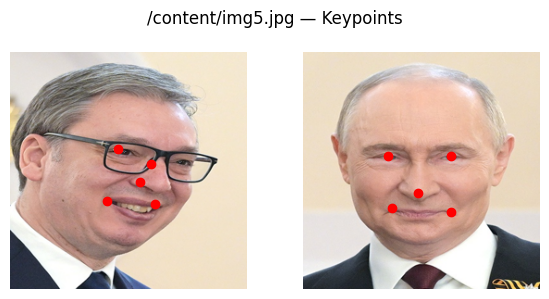

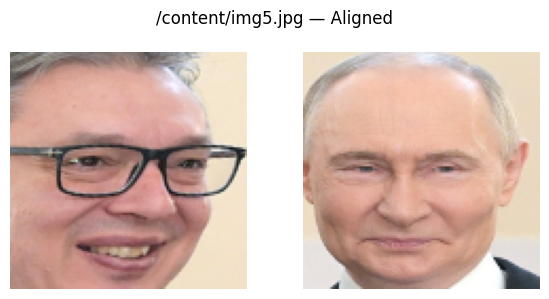

Найдено лиц: 3
Размер батча: torch.Size([3, 3, 256, 256])


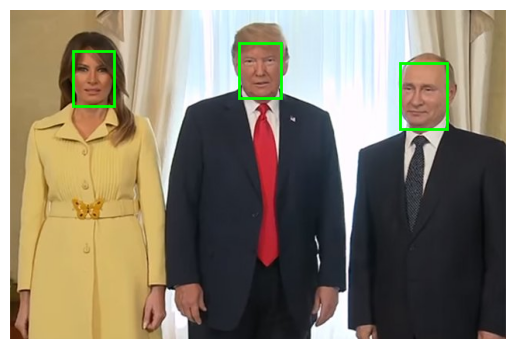

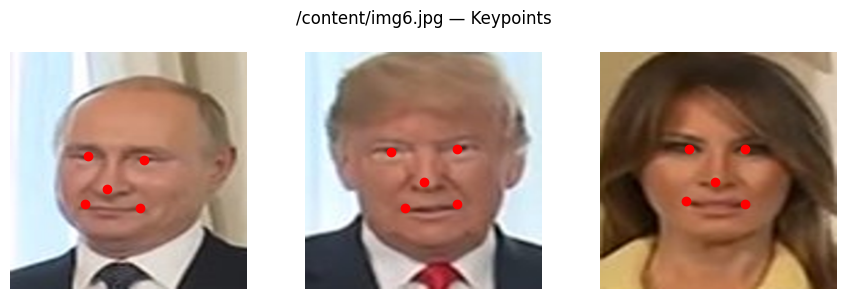

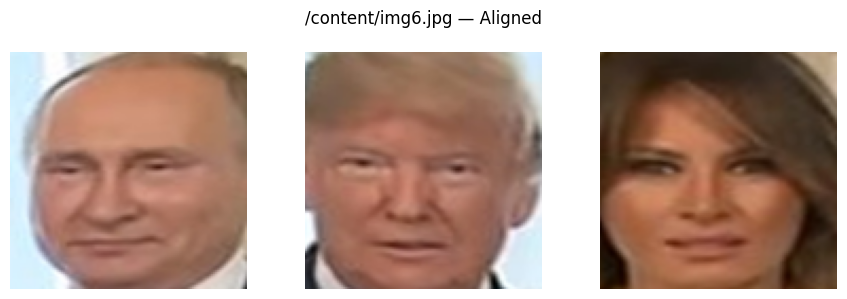

In [17]:
all_embs = []
all_faces = []
all_labels = []

for path in image_paths:
    embs, labels, faces, _ = process_image(path, hourglass, hybrid_backbone)
    all_embs.extend(embs)
    all_faces.extend(faces)
    all_labels.extend(labels)

embeddings = torch.stack(all_embs)
face_images = all_faces
labels = all_labels

results = compute_all_pairwise_metrics(embeddings, labels)

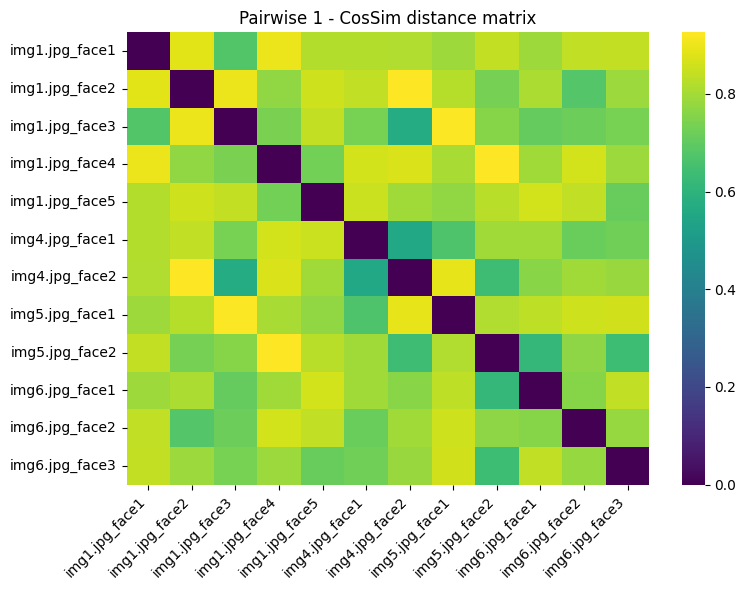

In [18]:
plot_distance_matrix(embeddings, labels, metric='cos')

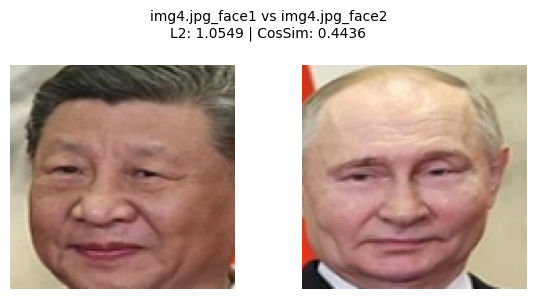

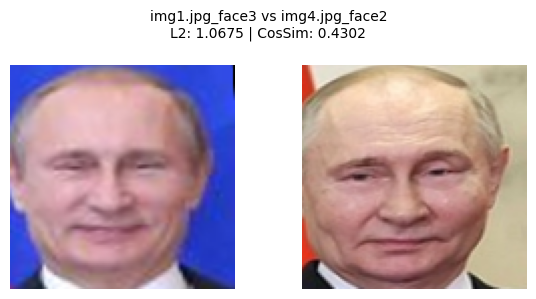

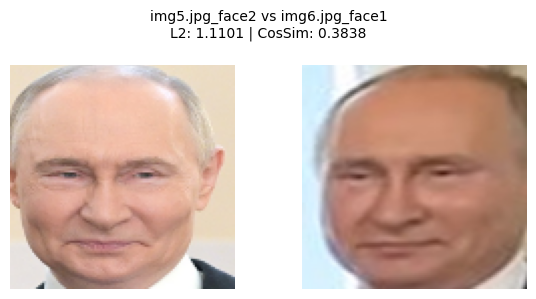

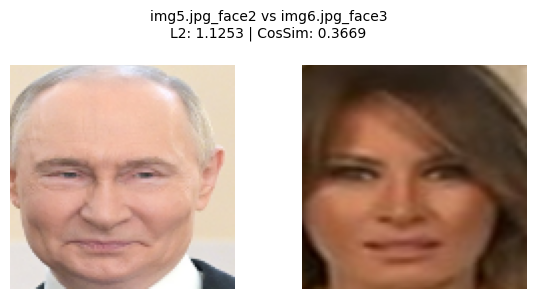

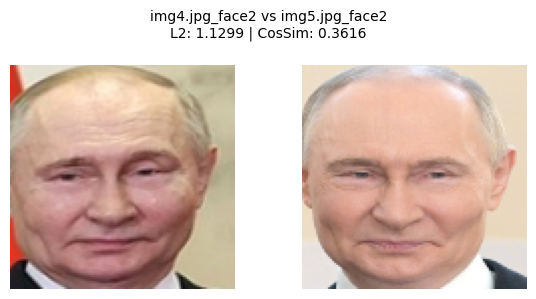

In [19]:
visualize_top_k_pairs(results, face_images, k=5)